In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Translated from MATLAB code, non-linearly separable

# Initialize seed for reproducibility
np.random.seed(1337)

# Generate Mackey-Glass time series

beta = 0.2
gamma = 0.1
n = 10
tau = 25

# Generate time series
t = np.arange(0, 2000, 1)

# Initialize x
x = np.zeros(len(t))

x[0] = 1.5

# Iteratively generate x
for i in range(len(t) - 1):
    x[i + 1] = x[i] + (beta * x[i - tau]) / (1 + x[i - tau] ** n) - gamma * x[i]
    
    
# Pick 1200 points from t=301 to t=1500 and define input and output
t = np.arange(301, 1501)

# Generate indices for the input and output
input_indices = [t - 20, t - 15, t - 10, t - 5, t]
output_indices = t + 5

input = np.vstack([x[idx] for idx in input_indices]).T
output = x[output_indices]

# Divide into training, validation and test sets
train_input = input[0:700, :]
train_output = output[0:700]

valid_input = input[700:1000, :]
valid_output = output[700:1000]

test_input = input[1000:1200, :]
test_output = output[1000:1200]


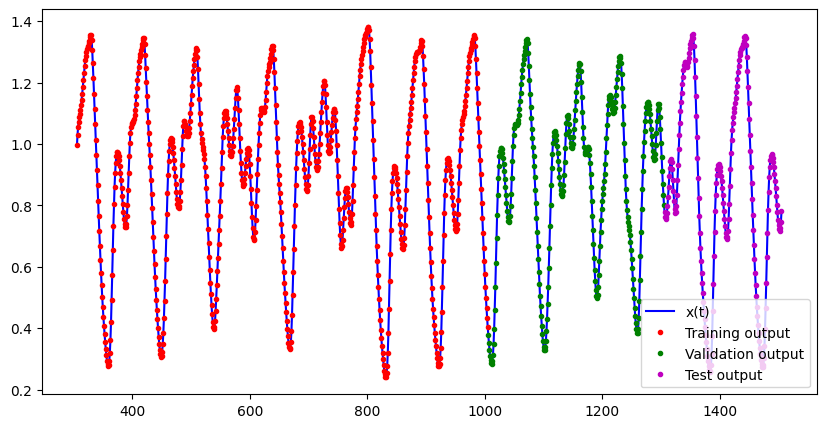

In [3]:
# Plot the train, valid and test output which are t + 5
plt.figure(figsize=(10, 5))
plt.plot((t+5), x[t+5], 'b-', label='x(t)')
plt.plot((t+5)[0:700], train_output, 'r.', label='Training output')
plt.plot((t+5)[700:1000], valid_output, 'g.', label='Validation output')
plt.plot((t+5)[1000:1200], test_output, 'm.', label='Test output')
plt.legend()
plt.savefig('MG_time_series_output.png')
plt.show()

In [4]:
# Define Keras model
nh1 = [3,4,5]
nh2 = [2,4,6]

models = []

# Intialize hyperparameters
batch_size = 25
epochs = 1000
lambda_ = 0.0001
tolerance = 0.0001

# Define the models and append to models list
for i in range(len(nh1)):
    for j in range(len(nh2)):
        model = Sequential()
        model.add(Dense(nh1[i], input_shape=(5,), activation='sigmoid', kernel_regularizer=l2(lambda_)))
        model.add(Dense(nh2[j], activation='sigmoid', kernel_regularizer=l2(lambda_)))
        model.add(Dense(1, activation='linear', kernel_regularizer=l2(lambda_)))
        model.compile(loss='mean_squared_error', optimizer='adam')
        models.append(model)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=tolerance, patience=5, restore_best_weights=True)

In [5]:
# Train models
histories = []
for model in models:
    history = model.fit(train_input, train_output, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(valid_input, valid_output), callbacks=[early_stopping])
    histories.append(history)
    
# Choose the best and worst models based on validation loss
val_losses = [history.history['val_loss'][-1] for history in histories]
best_model = models[np.argmin(val_losses)]
worst_model = models[np.argmax(val_losses)]

# Print their layer sizes
print('Best model layer sizes: ', [layer.output_shape for layer in best_model.layers])
print('Worst model layer sizes: ', [layer.output_shape for layer in worst_model.layers])

# Report test performance on the best and worst models
print('Best model test loss: ', best_model.evaluate(test_input, test_output))
print('Worst model test loss: ', worst_model.evaluate(test_input, test_output))

# How many epochs did it take to converge?
print('Best model epochs: ', len(histories[np.argmin(val_losses)].history['loss']))
print('Worst model epochs: ', len(histories[np.argmax(val_losses)].history['loss']))

# Save the best and worst models
best_model.save('models/best_model.h5')
worst_model.save('models/worst_model.h5')

Best model layer sizes:  [(None, 5), (None, 2), (None, 1)]
Worst model layer sizes:  [(None, 5), (None, 4), (None, 1)]
7/7 [==============================] - 0s 2ms/step - loss: 0.0175
Best model test loss:  0.017477858811616898
7/7 [==============================] - 0s 2ms/step - loss: 0.0985
Worst model test loss:  0.09848873317241669
Best model epochs:  370
Worst model epochs:  54


C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 1ms/step


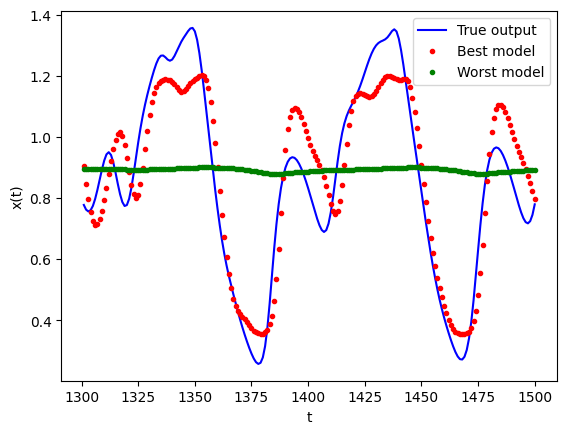

In [6]:
# Plot test predictions from the best and worst models

# X-axis should be 1301 to 1500 as this is the range of the test set
t_temp = np.arange(1301, 1501)
plt.plot(t_temp, test_output, 'b-', label='True output')
plt.plot(t_temp, best_model.predict(test_input), 'r.', label='Best model')
plt.plot(t_temp, worst_model.predict(test_input), 'g.', label='Worst model')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend()
plt.savefig('images/best_worst.png')
plt.show()


In [7]:
# Add zero-mean Gaussian noise to the training set
sigma = 0.05
train_input_noisy = train_input + np.random.normal(0, sigma, train_input.shape)

# [5, 2, 1] seemed like best architecture, try to search for second layer size
nh1 = [5]
nh2 = [3,6,9]

# Define the models and append to models list
models_new = []

# Intialize hyperparameters
batch_size = 25
epochs = 100
lambda_ = 0.0001

# Define the models and append to models list
for i in range(len(nh1)):
    for j in range(len(nh2)):
        model = Sequential()
        model.add(Dense(nh1[i], input_shape=(5,), activation='sigmoid', kernel_regularizer=l2(lambda_)))
        model.add(Dense(nh2[j], activation='sigmoid', kernel_regularizer=l2(lambda_)))
        model.add(Dense(1, activation='linear', kernel_regularizer=l2(lambda_)))
        model.compile(loss='mean_squared_error', optimizer='adam')
        models_new.append(model)

# No early stopping

10/10 [==============================] - 0s 1ms/step - loss: 0.0250
0.024980729445815086
10/10 [==============================] - 0s 2ms/step - loss: 0.0192
0.019206374883651733
10/10 [==============================] - 0s 1ms/step - loss: 0.0450
0.04504302144050598
7/7 [==============================] - 0s 1ms/step


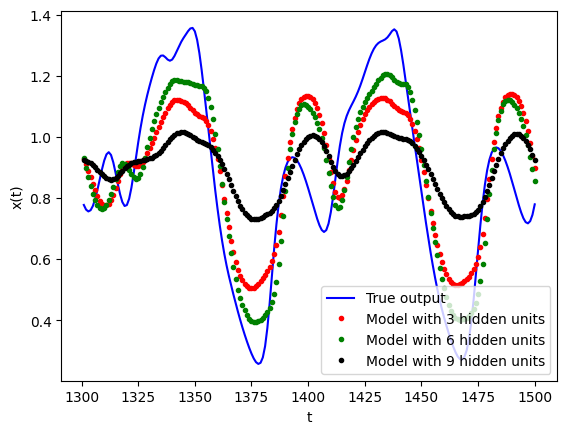

: 

In [8]:
# Train models
histories_new = []
for model in models_new:
    history = model.fit(train_input_noisy, train_output, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(valid_input, valid_output))
    histories_new.append(history)
    
# Print the validation loss for each model
for model in models_new:
    print(model.evaluate(valid_input, valid_output))

# Plot test predictions for all models
t = np.arange(1301, 1501)
plt.plot(t, test_output, 'b-', label='True output')
plt.plot(t, models_new[0].predict(test_input), 'r.', label='Model with 3 hidden units')
plt.plot(t, models_new[1].predict(test_input), 'g.', label='Model with 6 hidden units')
plt.plot(t, models_new[2].predict(test_input), 'k.', label='Model with 9 hidden units')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend()
plt.savefig('images/models_noisy_sigma005.png')
plt.show()
